In [1]:
print(__doc__)

# Code source adapted from: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
import os
import csv
import pprint
import time

pp = pprint.PrettyPrinter(indent=4)

Automatically created module for IPython interactive environment


In [42]:
def treat_dataset(dataset):
    vcut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    vcolor = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
    vclarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
    
    target = []
    new_data = []
    for row in dataset:
        # Modify string to number values
#         row["cut"] = vcut[row["cut"]]
#         row["color"] = vcolor[row["color"]]
#         row["clarity"] = vclarity[row["clarity"]]
        
        new_data.append([])
        nrow = new_data[len(new_data)-1]
        
        # Add X0 for ease of use
        nrow.append(1)
        
        # Create new values
        row["carat2"] = float(row["carat"])**2
        row["x2"] = float(row["x"])**2
        row["y2"] = float(row["y"])**2
        row["z2"] = float(row["z"])**2
        
        # Normalize values
        nrow.append(((float(row["carat"]) - (0.2+5.01)/2)/((0.2+5.01))))
#         nrow.append(((float(row["carat2"]) - (0.2+5.01)**2/2)/((0.2+5.01)**2)))
#         nrow.append((float(row["cut"]) - (4/2))/4)
#         nrow.append((float(row["color"]) - (6/2))/6)
#         nrow.append((float(row["clarity"]) - (7/2))/7)
        nrow.append((float(row["x"]) - (10.74/2))/(10.74))
#         nrow.append((float(row["x2"]) - (10.74**2/2))/(10.74**2))
        nrow.append((float(row["y"]) - (58.9/2))/(58.9))
#         nrow.append((float(row["y2"]) - (58.9**2/2))/(58.9**2))
        nrow.append((float(row["z"]) - (31.8/2))/(31.8))
#         nrow.append((float(row["z2"]) - (31.8**2/2))/(31.8**2))
        nrow.append((float(row["depth"]) - (43+79)/2)/(43+79))
        nrow.append((float(row["table"]) - (43+95)/2)/(43+95))
        
        # Add values for cut, color and clarity
        for k,v in vcolor.items():
            nrow.append(1 if row["color"]==k else 0)
        for k,v in vcut.items():
            nrow.append(1 if row["cut"]==k else 0)
        for k,v in vclarity.items():
            nrow.append(1 if row["clarity"]==k else 0)
        
        # Remove target element and insert into it's own list
        target.append(float(row["price"]))
        del row["price"]
    return new_data, target

In [44]:
# Read and treat training dataset
dataset_train = []
reader = csv.DictReader(open('diamonds-train.csv', 'r'))
for line in reader:
     dataset_train.append(line)

dataset_train, target_train = treat_dataset(dataset_train)

# Read and treat test dataset
dataset_test = []
reader = csv.DictReader(open('diamonds-test.csv', 'r'))
for line in reader:
     dataset_test.append(line)

dataset_test, target_test = treat_dataset(dataset_test)

# Auxilary vector for name to number mapping
ds_index = {"x0":0, "carat":1, "cut":2, "color":3, "clarity":4, "x":5, "y":6, "z":7, "depth":8, "table":9}

In [40]:
def calculate_cost_function(thetas, data, target, _lambda):
    m = len(data)
    s = 0
    
    # Regularization term
    reg = 0
    for t in thetas:
        reg += t*t
    reg *= _lambda
        
    for index in range(len(data)):
        h = 0
        h += thetas[0]
        for k in range(1, len(data[index])):
            h += thetas[k] * data[index][k]
        s += (h - float(target[index]))*(h - float(target[index]))
        
    return (1/(2*m)) * (s + reg)

def calculate_hfunction(features, thetas):
    h = 0
    for f in range(len(thetas)):
        h += thetas[f] * features[f]
    return h

def init_thetas(data):
    if len(data) == 0:
        return []
    thetas = []
    for k in range(len(data[0])):
        thetas.append(0)
    return thetas

def get_predictions(data, thetas):
    res = []
    for row in range(len(data)):
        res.append(np.matmul([data[row]],np.column_stack([thetas]))[0,0])
        
    return res

def graph_add_scatter(x, y, c='black'):
    plt.scatter(x, y, color= c)

def graph_add_line(x, y, c='black'):
    plt.plot(x, y, color=c, linewidth=3)

def plot(name=""):
    plt.xticks()
    plt.yticks()
    
    if name!="":
        plt.savefig(name)
    plt.show()
    plt.close()

def current_time():
    return int(round(time.time() * 1000))

In [5]:
#####################################
#                                   #
#    GRADIENT DESCENT ALGORITHM     #
#                                   #
#####################################

def gradient_descent(data, target, batch_size = 1, max_iterations = 100, stopCondition = 1e-04, learningRate = 1e-03, j_step=1000, _lambda = 0.01):

    thetas     = init_thetas(data)
    done       = False
    m          = len(data)
    iterations = 0

    # After j_step iterations, compute cost function
    costs       = []
    itr_numbers = []

    startTime = int(round(time.time() * 1000))
    while(iterations < max_iterations and not done):

        # Step through the dataset in chuncks
        for row in range(0, len(data), batch_size):
            new_thetas = thetas.copy()
            
            # Update theta 0 
            s = 0
            for offset in range(batch_size):
                if row + offset >= m:
                    break
                h = calculate_hfunction(data[row+offset], thetas)
                s = (h - float(target[row+offset])) * data[row+offset][0]
                
            new_thetas[0] = thetas[0] - ((learningRate / batch_size) * s)

            # For each theta we do the following
            for k in range(1, len(thetas)):

                s = 0
                # We add every row of the dataset to the error calculation (Batch)
                for offset in range(batch_size):
                    if row + offset >= m:
                        break

                    h = calculate_hfunction(data[row+offset], thetas)

                    s += (h - float(target[row+offset])) * data[row+offset][k]

                # Updating the new thetas vector values
                new_thetas[k] = thetas[k] * (1 - _lambda * learningRate / batch_size) - ((learningRate / batch_size) * s)

            if iterations % j_step == 0:
                cost = calculate_cost_function(thetas, data, target, _lambda)
                if len(costs)>0 and cost > costs[-1]:
                    learningRate /= 1.001
                costs.append(cost)
                itr_numbers.append(iterations)

            iterations = iterations + 1
            if iterations >= max_iterations:
                break

            # If the change in value for new thetas is too small, we can stop iterating
            done = True
            for k in range(len(thetas)):
                done = abs(thetas[k] - new_thetas[k]) < stopCondition and done
            if done:
                break

            # Atualization of the values of the thetas
            thetas = new_thetas.copy()

    if iterations >= max_iterations:
        print("Stopped by number of iterations\n")
    if done:
        print("Stopped by convergence\n")
    endTime = int(round(time.time() * 1000))
    print("RunTime = ", (endTime - startTime)/1000, " seconds")
    return thetas, itr_numbers, costs

Stopped by number of iterations

RunTime =  11524.028  seconds
Coefficients: 

[   8112.850746455748,
    25658.14200888291,
    17353.04869716241,
    -55.65995533895847,
    588.1065679909955,
    876.9754626441018,
    -1058.5984062375205,
    1717.6725404569445,
    1925.1055214451558,
    1016.9944573441264,
    1596.3568411574554,
    -206.16004771103826,
    631.5257449937689,
    1431.3556887692412,
    1041.6259021874257,
    1791.064063092339,
    1615.1393309164366,
    1772.6587633469724,
    1892.3626869125421,
    2668.329288802655,
    686.5859338534735,
    2337.6995718375456,
    2180.452418513403,
    -2608.9119166633172,
    -204.69185597652995,
    1675.8208482334285,
    1377.566457855057]

Mean absolute error: 950.61
54.979091663937474


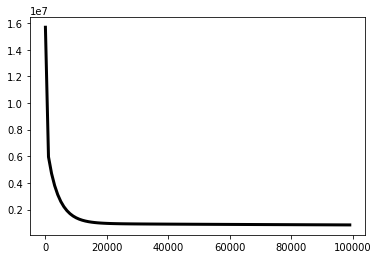

In [6]:
#####################################
#                                   #
#   MINI BATCH GRADIENT ALGORITHM   #
#                                   #
#####################################

max_iter=100000
b_size=1000
thetas_mbatch, itr_numbers, costs = gradient_descent(dataset_train, target_train, stopCondition = 0.00000001, learningRate=1e-02, max_iterations=max_iter, j_step=1000, batch_size=b_size)

print("Coefficients: \n")
pp.pprint(thetas_mbatch)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas_mbatch)))

error = 0
res = get_predictions(dataset_test, thetas_mbatch)
for i in range(len(res)):
    error += abs(target_test[i] - res[i]) / target_test[i]
error /= len(res)
print(error * 100)

graph_add_line(itr_numbers, costs)
plot("MB_costitr_mitr"+str(max_iter)+"_b"+str(b_size))
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

In [52]:
#####################################
#                                   #
#     BATCH GRADIENT ALGORITHM      #
#                                   #
#####################################

max_iter=10000
thetas_batch, itr_numbers, costs = gradient_descent(dataset_train, target_train, _lambda=0.00001, stopCondition = 0.00000001, batch_size=len(dataset_train), learningRate=1e-02, max_iterations=max_iter, j_step=1000)

print("Coefficients: \n")
pp.pprint(thetas_batch)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas_batch)))

error = 0
res = get_predictions(dataset_test, thetas_batch)
for i in range(len(res)):
    error += abs(target_test[i] - res[i]) / target_test[i]
error /= len(res)
print(error * 100)

graph_add_line(itr_numbers, costs)
plot("B_costitr_mitr"+str(max_iter))
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

KeyboardInterrupt: 

In [ ]:
#####################################
#                                   #
#       STOCHASTIC ALGORITHM        #
#                                   #
#####################################
max_iter=5000000
thetas_sto, itr_numbers, costs = gradient_descent(dataset_train, target_train, _lambda=0.0000005, stopCondition = 0.00000000001, batch_size=1, learningRate=0.01, max_iterations=max_iter, j_step=1000)

In [ ]:
print("Coefficients: \n")
pp.pprint(thetas_sto)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas_sto)))

print("\nVariance: %.2f"
      % explained_variance_score(target_test, get_predictions(dataset_test, thetas_sto)))

error = 0
res = get_predictions(dataset_test, thetas_sto)
for i in range(len(res)):
    error += abs(target_test[i] - res[i]) / target_test[i]
error /= len(res)
print(error * 100)

graph_add_line(itr_numbers, costs)
plot("S_costitr_mitr"+str(max_iter))
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

In [57]:
#####################################
#                                   #
#          NORMAL EQUATION          #
#                                   #
#####################################

mat_target = []

for row in range(len(target_train)):
    mat_target.append([target_train[row]])

mat_train = np.matrix(dataset_train)
mat_train_T = mat_train.transpose()
mat_target = np.matrix(mat_target)

identity = np.identity(len(dataset_train[0]))
identity[0,0] = 0
errors = []
lambdas = []
_lambda = 0
for i in range(1):
    thetas = np.matmul(np.matmul(inv(np.add(np.matmul(mat_train_T, mat_train), np.multiply(_lambda, identity))), mat_train_T), mat_target)
    lambdas.append(_lambda)
    errors.append(mean_absolute_error(target_train, get_predictions(dataset_train, thetas)))
    _lambda += 0.05

Coefficients: 

matrix([[-4.32927788e+18],
        [ 2.41748429e+06],
        [-2.56002081e+07],
        [ 1.04766002e+06],
        [ 1.13245367e+08],
        [-2.42837702e+07],
        [-3.23076435e+06],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [-1.84807647e+18],
        [ 6.17735436e+18],
        [ 6.17735436e+18],
        [ 6.17735436e+18],
        [ 6.17735436e+18],
        [ 6.17735436e+18],
        [-2.15537121e+05],
        [-1.99368165e+05],
        [-1.95532159e+05],
        [-2.07118494e+05],
        [-1.30712404e+05],
        [-2.12349423e+05],
        [-2.06468139e+05],
        [-2.05272363e+05]])

Mean absolute error: 82165.29


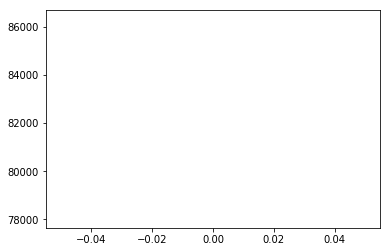

In [58]:
res = []
data = []
for rows in range(len(dataset_train)):
    data.append([1] + dataset_train[rows])
    res.append(np.matmul(dataset_train[rows],thetas)[0,0])

# error = 0
# for i in range(len(res)):
#     error += abs(target_test[i] - res[i]) / target_test[i]
# error /= len(res)
# print(error * 100)

print("Coefficients: \n")
pp.pprint(thetas)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_train, get_predictions(dataset_train, thetas)))

graph_add_line(lambdas, errors)
plot()

In [ ]:
#####################################
#                                   #
#     SKLEARN LINEAR REGRESSION     #
#                                   #
#####################################

# Create linear regression object
regr = linear_model.SGDRegressor(max_iter=100000, eta0=0.01)

# Train the model using the training sets
regr.fit(dataset_train, target_train)

# Make predictions using the validation set
diabetes_y_pred = regr.predict(dataset_test)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(target_test, diabetes_y_pred))

# Plot outputs
plt.scatter(get_feature(dataset_train, 'x'), target_train, color='gray')
plt.scatter(get_feature(dataset_test, 'x'), target_test, color='black')
plt.scatter(get_feature(dataset_test, 'x'), diabetes_y_pred, color='blue', linewidth=3)

plt.xticks()
plt.yticks()

plt.show()